## How to get high score using MMBT and CLIP in Hateful Memes Competition

#### Use CLIP as a feature encoder for Multimodal Bitransformer and make MMBT really work with Huggingface Transformers to get surprisingly high accuracy

The additional stage of <a href=https://www.drivendata.org/competitions/64/hateful-memes/>Hateful Memes Competition</a> from Facebook ended a few months ago. My team was lucky enough to take part in this competition and even get pretty good results (we took tenth place). How we did it and what methods we used - I'll tell you in this article. 

## Problem description

At first glance, the problem that had to be solved in the competition is quite simple - to determine whether a meme is hateful or not using text and image data from it. In reality, the problem is complicated by the many ambiguities inherent in our speech, as well as by the presence of sarcasm and irony, with the definition of which neural networks have problems. You can read more about the competition and the tasks it posed in the corresponding <a href=https://arxiv.org/pdf/2005.04790v2.pdf>paper</a>. 

<img src=https://drivendata-public-assets.s3.amazonaws.com/memes-overview.png />
Image from <a href=https://www.drivendata.org/competitions/64/hateful-memes/>DrivenData</a>

## Data Overview

During the competition, a downloadable zip file was provided. Now competition data can be found at this <a href=https://hatefulmemeschallenge.com/>link</a>.

The zip file includes a folder with images and several json files with images annotations.

<b>img/</b> folder contains all the images of the challenge dataset including train, dev and test split. The images are named \<id>.png, where \<id> is a unique 5 digit number.  

**train.jsonl, dev_seen.jsonl, dev_unseen.jsonl** — json files where each line has a dictionary of key-value pairs of data about the images. The dictionary includes

- **id** The unique identifier between the img directory and the .jsonl files, e.g., "id": 13894.
- **img** The actual meme filename, e.g., "img": img/13894.png, note that the filename contains the img directory described above, and that the filename stem is the id.
- **text** The raw text string embedded in the meme image, e.g., img/13894.png has "text": "putting bows on your pet"
- **label** where 1 -> "hateful" and 0 -> "non-hateful"


For example:

{"id":23058,"img":"img\/23058.png","label":0,"text":"don't be afraid to love again everyone is not like your ex"}

**test_seen.jsnol** includes mentioned keys, except <b>label</b>.

## Performance metric

Model performance and leaderboard rankings were determined using the **AUC ROC** or the Area Under the Curve of the Receiver Operating Characteristic. The metric measures how well your binary classifier discriminates between the classes as its decision threshold is varied. 

<img src=images/auroc.png />

Another metric was the accuracy of  predictions, given by the ratio of correct predictions to the total number of predictions made. 

<img src=images/accuracy.png />

## Our approach

There are many models and frameworks for working with multimodal data, the one that stands out the most is <a href=https://mmf.sh/>MMF</a> from Facebook. <a href=https://mmf.sh/>MMF</a> provides a simple interface for accessing many powerful multimodal models. But we, as big fans of <a href=https://github.com/huggingface/transformers>Huggingface Transformers</a>, decided not to go the easy way. We decided to find out what multimodal models are available in <a href=https://github.com/huggingface/transformers>Transformers</a> and how to get the most out of them. It turned out that only one model of this kind is currently available in Transformers - <b><a href="https://huggingface.co/transformers/summary.html#multimodal-models">Multimodal Bitransformer (MMBT)</a></b>. Making this model work was not so easy, but this made the task only more interesting. 

<img width='700px' src='images/MMBT.png'/>
MMBT architecture, from <a href='https://arxiv.org/abs/1909.02950'>Supervised Multimodal Bitransformers for Classifying Images and Text paper</a>

MMBT fuses information from text and image encoders. <a href='https://huggingface.co/transformers/model_doc/bert.html'>BERT</a> is used as text encoder and <a href='https://pytorch.org/hub/pytorch_vision_resnet/'>ResNet</a> as image encoder. We took advantage of MMBT architecture flexibility and replaced ResNet with <a href=https://github.com/openai/CLIP>CLIP</a> for image encoding.  <b>CLIP</b> pre-trains an image encoder and a text encoder to predict which images were paired with which texts in a dataset. Our assumption was that features from CLIP are more versatile and better suited for a multimodal domain.

<img width='700px' src='https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png'/>
Summary of CLIP model’s approach, from <a href='https://arxiv.org/abs/2103.00020'>Learning Transferable Visual Models From Natural Language Supervision paper</a>

For text encoding we used <a href=https://huggingface.co/Hate-speech-CNERG/bert-base-uncased-hatexplain>bert-base-uncased-hatexplain</a> model which is available in Huggingface Hub. This model was created for hatespeech detection in English, so in our case features from it are better than from <a href=https://huggingface.co/bert-base-uncased>bert-base-uncased</a> that was used in MMBT initially. 

Final MMBT model was finetuned on a train dataset and validated on dev_seen dataset.

We also augmented texts in train dataset using controlled <a href="https://huggingface.co/transformers/model_doc/gpt2.html">GPT-2</a> and <a href="https://github.com/dsfsi/textaugment#eda-easy-data-augmentation-techniques-for-boosting-performance-on-text-classification-tasks">Easy Data Augmentation</a> method. This increased the accuracy of our model by an additional few percent. Augmentation is beyond the scope of this article, and I will probably write about it separately if you find this article and our approach interesting. 

## Implementation

There will be a lot of code in this section of the article, but I will try to explain all the important parts in detail for a better understanding.

First, let's import the required libraries. We will need

- Transformers version >=4.8.2
- Pytorch version 1.8.1
- torchvision 0.9.1
- scikit-learn 0.23.2 
- Pillow >=8.2.0
- tqdm >= 4.60.0
- matplotlib >= 3.3.4
- numpy >=1.19.5
- <a href=https://github.com/openai/CLIP>CLIP</a> (that can be installed from repository). 

CLIP is now <a href=https://huggingface.co/transformers/model_doc/clip.html>accesible</a> directly in Huggingface Transformers, but at the time of the implementation of our approach it was not there yet. To get the most out of our model, we also used the <a href=https://github.com/facebookresearch/madgrad>MADGRAD</a> optimizer. 

In [2]:
!pip install tensorflow
!pip install keras
!pip install Transformers #version >=4.8.2
!pip install torch #version 1.8.1
!pip install torchvision #0.9.1
!pip install scikit-learn #0.23.2
!pip install Pillow #>=8.2.0
!pip install tqdm #>= 4.60.0
!pip install matplotlib #>= 3.3.4
!pip install numpy #>=1.19.5
!pip install git+https://github.com/openai/CLIP.git
!pip install madgrad

  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached tokenizers-0.13.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached regex-2022.10.31-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (757 kB)
  Using cached huggingface_hub-0.13.4-py3-none-any.whl (200 kB)
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xepycb3f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xepycb3f
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=0978d9fd19be452d6ee9db43fe4ebeb2aefc8be11a5d06de18b2bcbba349246b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fi_zmlf7/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built cl

In [3]:
import json
import os
from collections import Counter
import random
import numpy as np

import torch
import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from madgrad import MADGRAD

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import clip
import pickle

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import copy

import transformers
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    MMBTConfig,
    MMBTModel,
    MMBTForClassification,
    get_linear_schedule_with_warmup,
)

2023-04-21 22:13:08.291110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 22:13:22.390327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-21 22:13:22.400268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [5]:
#import tensorflow as tf
#print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Create a variable with available device, which will do all needed computations. We will need a GPU, so our device is CUDA.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Load CLIP model and needed preprocessing.

In [7]:
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)

Freeze weights of CLIP feature encoder, as we will not finetune it. 

In [8]:
for p in clip_model.parameters():
    p.requires_grad = False

Initialize needed variables.

In [9]:
num_image_embeds = 4
num_labels = 1
gradient_accumulation_steps = 20
data_dir = 'data'
max_seq_length = 80 
max_grad_norm = 0.5
train_batch_size = 16
eval_batch_size = 16
image_encoder_size = 288
image_features_size = 640
num_train_epochs = 5

Create a function that will prepare an image for CLIP encoder in a special manner. This function will split image into three tiles (by height or width, depending on the aspect ratio of the image). Finally we will get four vectors after encoding (one vector for each tile and one vector for whole image that was padded to square).

In [10]:
def slice_image(im, desired_size):
    '''
    Resize and slice image
    '''
    old_size = im.size  

    ratio = float(desired_size)/min(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im = im.resize(new_size, Image.ANTIALIAS)
    
    ar = np.array(im)
    images = []
    if ar.shape[0] < ar.shape[1]:
        middle = ar.shape[1] // 2
        half = desired_size // 2
        
        images.append(Image.fromarray(ar[:, :desired_size]))
        images.append(Image.fromarray(ar[:, middle-half:middle+half]))
        images.append(Image.fromarray(ar[:, ar.shape[1]-desired_size:ar.shape[1]]))
    else:
        middle = ar.shape[0] // 2
        half = desired_size // 2
        
        images.append(Image.fromarray(ar[:desired_size, :]))
        images.append(Image.fromarray(ar[middle-half:middle+half, :]))
        images.append(Image.fromarray(ar[ar.shape[0]-desired_size:ar.shape[0], :]))

    return images

In [11]:
def resize_pad_image(im, desired_size):
    '''
    Resize and pad image to a desired size
    '''
    old_size = im.size  

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im = im.resize(new_size, Image.ANTIALIAS)

    # create a new image and paste the resized on it
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    return new_im

Define a function, that will get image features from CLIP.

In [12]:
class ClipEncoderMulti(nn.Module):
    def __init__(self, num_embeds, num_features=image_features_size):
        super().__init__()        
        self.model = clip_model
        self.num_embeds = num_embeds
        self.num_features = num_features

    def forward(self, x):
        # 4x3x288x288 -> 1x4x640
        out = self.model.encode_image(x.view(-1,3,288,288))
        out = out.view(-1, self.num_embeds, self.num_features).float()
        return out  # Bx4x640

In [13]:
# image_encoder = ClipEncoderMulti(4)
# image = Image.open("dataset/img/42953.png").convert("RGB")

# sliced_images = slice_image(image, 288)
# sliced_images = [np.array(preprocess(im)) for im in sliced_images] 

# image = resize_pad_image(image, image_encoder_size)
# image = np.array(preprocess(image))

# sliced_images = [image] + sliced_images
# sliced_images = torch.from_numpy(np.array(sliced_images)).to(device)

# print(sliced_images.shape)
# print(image_encoder(sliced_images).shape)

In [14]:
# im = Image.open("dataset/img/01576.png").convert("RGB")
# sliced_images = slice_image(im, 288) 
# for img in sliced_images:
#     plt.figure()
#     plt.imshow(img)
#     print(img.size)

Create JsonlDataset class that will load texts and preprocessed images. <b>collate_fn</b> will group data from dataset in a format needed for our pytorch model.

In [15]:
class JsonlDataset(Dataset):
    def __init__(self, data_path, tokenizer, transforms, max_seq_length):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = torch.LongTensor(self.tokenizer.encode(self.data[index]["text"], add_special_tokens=True))
        start_token, sentence, end_token = sentence[0], sentence[1:-1], sentence[-1]
        sentence = sentence[:self.max_seq_length]

        label = torch.FloatTensor([self.data[index]["label"]])

        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        sliced_images = slice_image(image, 288)
        sliced_images = [np.array(self.transforms(im)) for im in sliced_images]
        image = resize_pad_image(image, image_encoder_size)
        image = np.array(self.transforms(image))
        
        sliced_images = [image] + sliced_images         
        sliced_images = torch.from_numpy(np.array(sliced_images)).to(device)

        return {
            "image_start_token": start_token,            
            "image_end_token": end_token,
            "sentence": sentence,
            "image": sliced_images,
            "label": label            
        }

    def get_label_frequencies(self):
        label_freqs = Counter()
        for row in self.data:
            label_freqs.update([row["label"]])
        return label_freqs
    
    def get_labels(self):
        labels = []
        for row in self.data:
            labels.append(row["label"])
        return labels

In [16]:
def collate_fn(batch):
    lens = [len(row["sentence"]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)
    text_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        text_tensor[i_batch, :length] = input_row["sentence"]
        mask_tensor[i_batch, :length] = 1
    
    img_tensor = torch.stack([row["image"] for row in batch])
    tgt_tensor = torch.stack([row["label"] for row in batch])
    img_start_token = torch.stack([row["image_start_token"] for row in batch])
    img_end_token = torch.stack([row["image_end_token"] for row in batch])

    return text_tensor, mask_tensor, img_tensor, img_start_token, img_end_token, tgt_tensor

Define **load_examples** function that will load data described in json dataset into JsonlDataset object.

In [17]:
def load_examples(tokenizer, evaluate=False):
    path = os.path.join(data_dir, "dev.jsonl" if evaluate else f"train.jsonl")
    transforms = preprocess
    dataset = JsonlDataset(path, tokenizer, transforms, max_seq_length - num_image_embeds - 2)
    return dataset

Create functions to load and save model weights.

In [18]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

Needed functions and classes are created, so we can load our models.

In [19]:
model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'
transformer_config = AutoConfig.from_pretrained(model_name) 
transformer = AutoModel.from_pretrained(model_name, config=transformer_config)
img_encoder = ClipEncoderMulti(num_image_embeds)

Some weights of the model checkpoint at Hate-speech-CNERG/bert-base-uncased-hatexplain were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [21]:
config = MMBTConfig(transformer_config, num_labels=num_labels, modal_hidden_size=image_features_size)
model = MMBTForClassification(config, transformer, img_encoder)

In [22]:
model.to(device);

Load train and evaluation datasets and create dataloaders for these datasets.

In [23]:
train_dataset = load_examples(tokenizer, evaluate=False)
eval_dataset = load_examples(tokenizer, evaluate=True)   

train_sampler = RandomSampler(train_dataset)
eval_sampler = SequentialSampler(eval_dataset)

train_dataloader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=train_batch_size,
        collate_fn=collate_fn
    )


eval_dataloader = DataLoader(
        eval_dataset, 
        sampler=eval_sampler, 
        batch_size=eval_batch_size, 
        collate_fn=collate_fn
    )

Define model training parameters, optimizer and loss.

In [24]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", 
            "LayerNorm.weight"
           ]
weight_decay = 0.0005

optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

t_total = (len(train_dataloader) // gradient_accumulation_steps) * num_train_epochs
warmup_steps = t_total // 10

optimizer = MADGRAD(optimizer_grouped_parameters, lr=2e-4)

scheduler = get_linear_schedule_with_warmup(
        optimizer, warmup_steps, t_total
    )

criterion = nn.BCEWithLogitsLoss()

Define evaluation function that will take evaluation dataloader and calculate prediction AUC, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">F1 score</a> and accuracy.

In [25]:
def evaluate(model, tokenizer, criterion, dataloader, tres = 0.5): 
    
    # Eval!
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    proba = None
    out_label_ids = None
    for batch in dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            labels = batch[5]
            inputs = {
                "input_ids": batch[0],
                "input_modal": batch[2],
                "attention_mask": batch[1],
                "modal_start_tokens": batch[3],
                "modal_end_tokens": batch[4],
                "return_dict": False
            }
            outputs = model(**inputs)
            logits = outputs[0]  # model outputs are always tuple in transformers (see doc)
            tmp_eval_loss = criterion(logits, labels)
            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = torch.sigmoid(logits).detach().cpu().numpy() > tres
            proba = torch.sigmoid(logits).detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:            
            preds = np.append(preds, torch.sigmoid(logits).detach().cpu().numpy() > tres, axis=0)
            proba = np.append(proba, torch.sigmoid(logits).detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, labels.detach().cpu().numpy(), axis=0)
    
    eval_loss = eval_loss / nb_eval_steps

    result = {
        "loss": eval_loss,
        "accuracy": accuracy_score(out_label_ids, preds),
        "AUC": roc_auc_score(out_label_ids, proba),
        "micro_f1": f1_score(out_label_ids, preds, average="micro"),
        "prediction": preds,
        "labels": out_label_ids,
        "proba": proba
    }
    
    return result

Finally we can train our model. We specify minimun needed AUC value in <b>best_valid_auc</b> variable, so if the model achieves higher AUC on validation data than it was specified, we will save that model.

In [26]:
optimizer_step = 0
global_step = 0
train_step = 0
tr_loss, logging_loss = 0.0, 0.0
best_valid_auc = 0.75
global_steps_list = []
train_loss_list = []
val_loss_list = []
val_acc_list = []
val_auc_list = []
eval_every = len(train_dataloader) // 7
running_loss = 0
file_path="models/"

model.zero_grad()

for i in range(num_train_epochs):
    print("Epoch", i+1, f"from {num_train_epochs}")
    whole_y_pred=np.array([])
    whole_y_t=np.array([])
    for step, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = tuple(t.to(device) for t in batch)
        labels = batch[5]
        inputs = {
            "input_ids": batch[0],
            "input_modal": batch[2],
            "attention_mask": batch[1],
            "modal_start_tokens": batch[3],
            "modal_end_tokens": batch[4],
            "return_dict": False
        }
        outputs = model(**inputs)
        logits = outputs[0]  # model outputs are always tuple in transformers (see doc)
        loss = criterion(logits, labels)        
        
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
            
        loss.backward()
        
        tr_loss += loss.item()
        running_loss += loss.item()
        global_step += 1
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()  # Update learning rate schedule         
            
            optimizer_step += 1
            optimizer.zero_grad()   
                        
        if (step + 1) % eval_every == 0:
            
            average_train_loss = running_loss / eval_every
            train_loss_list.append(average_train_loss)
            global_steps_list.append(global_step)
            running_loss = 0.0  
            
            val_result = evaluate(model, tokenizer, criterion, eval_dataloader)
            
            val_loss_list.append(val_result['loss'])
            val_acc_list.append(val_result['accuracy'])
            val_auc_list.append(val_result['AUC'])
            
            # checkpoint
            if val_result['AUC'] > best_valid_auc:
                best_valid_auc = val_result['AUC']
                val_loss = val_result['loss']
                val_acc = val_result['accuracy']
                model_path = f'{file_path}/model-embs{num_image_embeds}-seq{max_seq_length}-auc{best_valid_auc:.3f}-loss{val_loss:.3f}-acc{val_acc:.3f}.pt'
                print(f"AUC improved, so saving this model")  
                save_checkpoint(model_path, model, val_result['loss'])              
            
            print("Train loss:", f"{average_train_loss:.4f}", 
                  "Val loss:", f"{val_result['loss']:.4f}",
                  "Val acc:", f"{val_result['accuracy']:.4f}",
                  "AUC:", f"{val_result['AUC']:.4f}")   
    print('\n')

Epoch 1 from 5


  0%|          | 0/532 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0340 Val loss: 0.7165 Val acc: 0.5060 AUC: 0.4495


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0332 Val loss: 0.7312 Val acc: 0.5040 AUC: 0.5475


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0323 Val loss: 0.7514 Val acc: 0.5320 AUC: 0.5994


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0307 Val loss: 0.7433 Val acc: 0.5260 AUC: 0.6217


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0290 Val loss: 0.8474 Val acc: 0.5200 AUC: 0.6252


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0277 Val loss: 0.7327 Val acc: 0.5860 AUC: 0.6257


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0288 Val loss: 0.7183 Val acc: 0.5400 AUC: 0.6455


Epoch 2 from 5


  0%|          | 0/532 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0282 Val loss: 0.7218 Val acc: 0.5600 AUC: 0.6499


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0273 Val loss: 0.7591 Val acc: 0.5760 AUC: 0.6430


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0264 Val loss: 0.7198 Val acc: 0.5840 AUC: 0.6538


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0267 Val loss: 0.9618 Val acc: 0.5200 AUC: 0.6577


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0269 Val loss: 0.6555 Val acc: 0.6100 AUC: 0.6663


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0276 Val loss: 0.8502 Val acc: 0.5280 AUC: 0.6771


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0273 Val loss: 0.6953 Val acc: 0.6140 AUC: 0.6844


Epoch 3 from 5


  0%|          | 0/532 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0245 Val loss: 0.7342 Val acc: 0.5740 AUC: 0.6959


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0239 Val loss: 0.9867 Val acc: 0.5560 AUC: 0.6923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0259 Val loss: 0.6825 Val acc: 0.6360 AUC: 0.6965


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0229 Val loss: 0.8375 Val acc: 0.5600 AUC: 0.7059


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0226 Val loss: 0.6983 Val acc: 0.6400 AUC: 0.7052


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0241 Val loss: 0.9747 Val acc: 0.5540 AUC: 0.7110


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0237 Val loss: 0.6691 Val acc: 0.6120 AUC: 0.7089


Epoch 4 from 5


  0%|          | 0/532 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0207 Val loss: 0.7381 Val acc: 0.5960 AUC: 0.7245


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0191 Val loss: 0.7769 Val acc: 0.6420 AUC: 0.7270


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0204 Val loss: 0.8571 Val acc: 0.6040 AUC: 0.7194


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0190 Val loss: 0.8435 Val acc: 0.6160 AUC: 0.7298


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0193 Val loss: 0.8026 Val acc: 0.6100 AUC: 0.7311


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0222 Val loss: 0.8092 Val acc: 0.6020 AUC: 0.7379


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0208 Val loss: 0.7277 Val acc: 0.6220 AUC: 0.7423


Epoch 5 from 5


  0%|          | 0/532 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0172 Val loss: 0.9175 Val acc: 0.5740 AUC: 0.7394


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0168 Val loss: 0.7220 Val acc: 0.6680 AUC: 0.7358


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0174 Val loss: 0.9896 Val acc: 0.5980 AUC: 0.7343


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0176 Val loss: 0.8049 Val acc: 0.6380 AUC: 0.7416


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0151 Val loss: 0.7837 Val acc: 0.6420 AUC: 0.7392


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0160 Val loss: 0.8611 Val acc: 0.6120 AUC: 0.7431


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Train loss: 0.0152 Val loss: 0.8698 Val acc: 0.6120 AUC: 0.7451




After training is complete, we can visualize results:

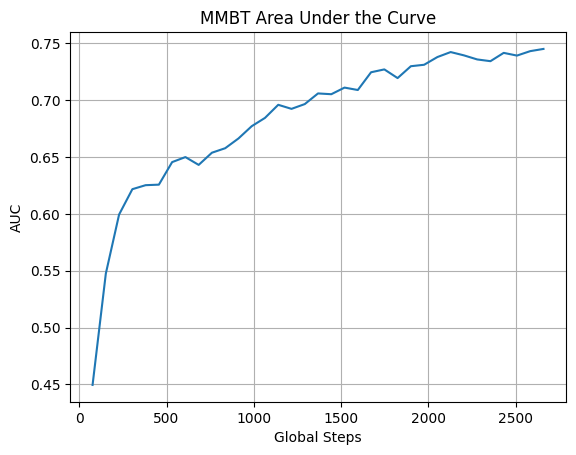

In [27]:
plt.plot(global_steps_list, val_auc_list)
plt.grid()
plt.xlabel('Global Steps')
plt.ylabel('AUC')
plt.title('MMBT Area Under the Curve')
plt.show() 

## Make predictions for submission

Now we can make a prediction for test data. Firstly we will create needed classes and functions for data loading and processing by analogy with the training stage.

In [28]:
import pandas as pd

In [35]:
num_labels = 1
data_dir = 'data'
test_batch_size = 16

In [36]:
class TestJsonlDataset(Dataset):
    def __init__(self, data_path, tokenizer, transforms, max_seq_length):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = torch.LongTensor(self.tokenizer.encode(self.data[index]["text"], add_special_tokens=True))
        start_token, sentence, end_token = sentence[0], sentence[1:-1], sentence[-1]
        sentence = sentence[:self.max_seq_length]

        id = torch.LongTensor([self.data[index]["id"]])        
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        sliced_images = slice_image(image, 288)
        sliced_images = [np.array(self.transforms(im)) for im in sliced_images]
        image = resize_pad_image(image, image_encoder_size)
        image = np.array(self.transforms(image))        
        sliced_images = [image] + sliced_images        
        sliced_images = torch.from_numpy(np.array(sliced_images)).to(device)

        return {
            "image_start_token": start_token,            
            "image_end_token": end_token,
            "sentence": sentence,
            "image": sliced_images,
            "id": id,
        }
    
def final_collate_fn(batch):
    lens = [len(row["sentence"]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)
    text_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        text_tensor[i_batch, :length] = input_row["sentence"]
        mask_tensor[i_batch, :length] = 1

    img_tensor = torch.stack([row["image"] for row in batch])
    id_tensor = torch.stack([row["id"] for row in batch])
    img_start_token = torch.stack([row["image_start_token"] for row in batch])
    img_end_token = torch.stack([row["image_end_token"] for row in batch])

    return text_tensor, mask_tensor, img_tensor, img_start_token, img_end_token, id_tensor

def load_test_examples(test_file="test.jsonl"):
    path = os.path.join(data_dir, test_file)
    dataset = TestJsonlDataset(path, tokenizer, preprocess, max_seq_length - num_image_embeds - 2)
    return dataset

def final_prediction(model, dataloader): 
    preds = None
    proba = None
    all_ids = None
    for batch in tqdm(dataloader):
        model.eval()
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            ids = batch[5]
            inputs = {
                "input_ids": batch[0],
                "input_modal": batch[2],
                "attention_mask": batch[1],
                "modal_start_tokens": batch[3],
                "modal_end_tokens": batch[4],
                "return_dict": False
            }
            outputs = model(**inputs)
            logits = outputs[0]
        if preds is None:
            all_ids = ids.detach().cpu().numpy()
            preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
            proba = torch.sigmoid(logits).detach().cpu().numpy()            
        else:  
            all_ids = np.append(all_ids, ids.detach().cpu().numpy(), axis=0)
            preds = np.append(preds, torch.sigmoid(logits).detach().cpu().numpy() > 0.5, axis=0)
            proba = np.append(proba, torch.sigmoid(logits).detach().cpu().numpy(), axis=0)
    
    result = {
        "ids": all_ids,
        "preds": preds,
        "probs": proba,
    }
    
    return result

In [37]:
final_test = load_test_examples()

In [38]:
final_test_sampler = SequentialSampler(final_test)

final_test_dataloader = DataLoader(
        final_test, 
        sampler=final_test_sampler, 
        batch_size=test_batch_size, 
        collate_fn=final_collate_fn
    )

Finally we make a prediction and save it in a specified format.

In [39]:
results = final_prediction(model, final_test_dataloader)

results['ids'] = results['ids'].reshape(-1)
results['preds'] = results['preds'].reshape(-1)
results['probs'] = results['probs'].reshape(-1)

df = pd.DataFrame(results)
df = df[['ids', 'probs', 'preds']]
df.columns = ['id', 'proba', 'label']
df.label = df.label.astype(int)

df.to_csv('final_multimodal_prediction.csv', index=False, float_format='%.3f')

  0%|          | 0/63 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


Thats it. In case the competition reopens, this prediction file can be sent there immediately. 

## Conclusion

In this article I tried to describe in detail the concept and implementation of the approach that we used in Hateful Memes Competition from Facebook. The tasks that the competition set for us turned out to be extremely interesting and we had a lot of fun developing our approach to solve these tasks. I hope you enjoyed reading this article too. 

I also want to mention that to obtain maximum AUC, we combined the prediction of several variants of this model trained with different loss parameters and different augmentation options. But that's a topic for an entirely different article. 